In [1]:
# https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html?source=post_page-----319e7090da5--------------------------------
#https://stackoverflow.com/questions/50805634/how-to-create-mask-images-from-coco-dataset

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import random

import torch
import torch.utils.data as data

import numpy as np

from pycocotools.coco import COCO

import torchvision
from torchvision.io import read_image
from torchvision import tv_tensors
from torchvision.transforms import v2 as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.utils import draw_bounding_boxes

from helpers.engine import train_one_epoch, evaluate, eval_forward

import matplotlib.pyplot as plt

import tqdm

from pickle import load, dump

from bidict import bidict

In [3]:
path_base = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'Data', 'data_sorted')
coco_annotations_file_root = os.path.join(path_base,'labels', 'COCO')
coco_images_dir_root = os.path.join(path_base, 'frames')

In [ ]:
def merge_keys(ds):
    keys = set.union(*map(set, ds))
    return keys

dict_list = []

for j in os.listdir(coco_images_dir_root):
    coco_annotations_file = os.path.join(coco_annotations_file_root, j+'.json')
    coco = COCO(coco_annotations_file)
    count_dict = {}
    classes = []
    for x in coco.cats:
        classes.append(coco.cats[x]['name'])
    
    for x in classes:
        catIds = coco.getCatIds(catNms=x) 
        if 66 in catIds:
            print('stop')
        for y in catIds:
            imgIds = coco.getImgIds(catIds=y)
            if len(imgIds) > 0:
                count_dict[x] =  len(imgIds)

    dict_list.append(count_dict)

keys = merge_keys(dict_list)
name_dict = dict.fromkeys(keys, 0)
name_dict.update((k, i+1) for i, k in enumerate(name_dict))
name_dict['No Annotation'] = len(name_dict)+1
name_bidict = bidict(name_dict)

In [ ]:
name_bidict

In [10]:
class AnnotationDataset(torch.utils.data.Dataset):

    def __init__(self, root, annotation):
        self.root = root
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        
        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
        
        #Add emptiness to not annotated frames
        if not boxes:
            boxes.append([0,0,1280,720])


        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        labels = []
        for i in range(num_objs):
            labels.append(coco_annotation[i]['category_id'])
        
        if not labels:
            labels.append(110)

        new_labels = []
        for x in labels:
            cat = coco.loadCats(x)
            name = cat[0]['name']
            new_labels.append(name_bidict.get(name))
        
        
        labels = torch.as_tensor(new_labels, dtype=torch.int64)

        # img_id
        img_id = int(img_id)

        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
            
        
        if not areas:
            areas.append((boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]))
        
        #areas = torch.as_tensor(areas, dtype=torch.float32)
        areas = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        if iscrowd.numel() == 0:
            iscrowd = torch.zeros((1,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["coco"] = self.coco
        my_annotation["root"] = self.root
        my_annotation["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=[720, 1280])
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        return my_annotation
    
    def __len__(self):
        return len(self.ids)

In [7]:
class TrainingsDataset(torch.utils.data.Dataset):
    def __init__(self, labels, transforms=None):
        self.labels = labels
        self.transforms = transforms
    

    def __getitem__(self, index):
        coco = self.labels[index]["coco"]
        root = self.labels[index]["root"]
        img_id = self.labels[index]["image_id"]
        path = coco.loadImgs(img_id)[0]['file_name']
        
        img = read_image(os.path.join(root, path))
        img = tv_tensors.Image(img)
        
        my_annotation = {}
        my_annotation["boxes"] = self.labels[index]["boxes"]
        my_annotation["labels"] = self.labels[index]["labels"]
        my_annotation["image_id"] = img_id
        my_annotation["area"] = self.labels[index]["area"]
        my_annotation["iscrowd"] = self.labels[index]["iscrowd"]
       
        if self.transforms is not None:
            img, my_annotation = self.transforms(img, my_annotation)

        return img, my_annotation

    def __len__(self):
        return len(self.labels)

In [27]:
def get_transform(train, h_flip, v_flip):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(h_flip))
        transforms.append(T.RandomVerticalFlip(v_flip))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [8]:
def collate_fn(batch):
    return tuple(zip(*batch))


In [ ]:
ds_list = []
for j in os.listdir(coco_images_dir_root):
    if 'p1_v4' in j:
        print('skipped')
    else:
        coco_annotations_file = os.path.join(coco_annotations_file_root, j+'.json')
        coco_images_dir = os.path.join(coco_images_dir_root, j)
        ds_list.append(AnnotationDataset(root=coco_images_dir, annotation=coco_annotations_file))

concat_ds_list = data.ConcatDataset(ds_list)     

In [ ]:
len(concat_ds_list)

In [71]:
with open(os.path.dirname(os.getcwd()) + "\\Object_Detection\\dataloaders\\labels.pkl", "rb") as input_file:
   annotated_labels = load(input_file)

In [72]:
with open(os.path.dirname(os.getcwd()) + "\\Object_Detection\\dataloaders\\names_to_annotation.pkl", "rb") as input_file:
   names_to_annotation = load(input_file)

In [18]:
counter = {}
for x in annotated_labels:
    labels = x['labels']
    for l in labels.numpy():
        name = name_bidict.inv.get(l)
        if name in counter.keys():
            counter[name] = counter[name]+1
        else:
            counter[name] = 1

In [20]:
len(counter)

32

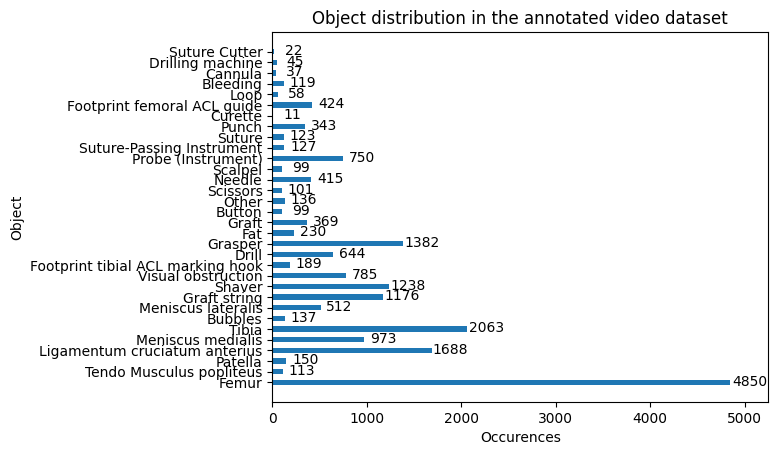

<Figure size 108000x192000 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt

labels = list(counter.keys())
values = list(counter.values())



plt.barh(labels, values, height=0.5, align='center')
plt.title('Object distribution in the annotated video dataset')
plt.xlabel('Occurences')
plt.ylabel('Object')

for i, value in enumerate(values):
    plt.text(value + 200, i-0.3, str(value), ha='center')

plt.xlim(0,5250)
plt.figure(figsize=(1080, 1920))
plt.show()

In [ ]:
names_to_annotation

In [25]:
with open(os.path.dirname(os.getcwd()) + "\\Object_Detection\\dataloaders\\labels_counter.pkl", 'wb') as file:
        dump(counter, file)

In [13]:
def evaluate_loss(model, data_loader, device):
    val_loss = 0
    with torch.no_grad():
      for images, targets in data_loader:
          images = list(image.to(device) for image in images)
          targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
          loss_dict, detections = eval_forward(model, images, targets)
         
          losses = sum(loss for loss in loss_dict.values())

          val_loss += losses
          
    validation_loss = val_loss/ len(data_loader)    
    return validation_loss

In [ ]:
annotated_labels = []

for x in tqdm.tqdm(concat_ds_list):
        dicty = x
        if len(dicty['labels']) > 1:
                annotated_labels.append(dicty)
        elif len(dicty['labels']) == 1:
            y = dicty['labels'].item()
            if  name_bidict.inv.get(y) != "No Annotation":
                annotated_labels.append(dicty)

  0%|          | 0/449658 [00:00<?, ?it/s]

100%|██████████| 449658/449658 [00:42<00:00, 10650.42it/s]


In [21]:
with open(os.path.dirname(os.getcwd()) + "\\Object_Detection\\dataloaders\\labels.pkl", 'wb') as file:
        dump(annotated_labels, file)

In [26]:
with open(os.path.dirname(os.getcwd()) + "\\Object_Detection\\dataloaders\\labels_no_empty.pkl", "rb") as input_file:
   annotated_labels = load(input_file)

In [ ]:
len(annotated_labels)

In [28]:
annotated_ds = []

annotated_ds.append(TrainingsDataset(annotated_labels, transforms=get_transform(train=True, h_flip=0, v_flip=0)))
annotated_ds.append(TrainingsDataset(annotated_labels, transforms=get_transform(train=True, h_flip=1, v_flip=0)))
annotated_ds.append(TrainingsDataset(annotated_labels, transforms=get_transform(train=True, h_flip=0, v_flip=1)))
annotated_ds.append(TrainingsDataset(annotated_labels, transforms=get_transform(train=True, h_flip=1, v_flip=1)))

In [ ]:
annotated_ds[0].__getitem__(1)

In [29]:
concat_ds = data.ConcatDataset(annotated_ds)

generator1 = torch.Generator().manual_seed(99)
annotated_ds_train, annotated_ds_test = data.random_split(concat_ds, [0.8, 0.2], generator1)

In [ ]:
len(concat_ds)

In [ ]:
annotated_ds_train[2062]

In [31]:
train_batch_size = 4

annotated_data_loader = data.DataLoader(annotated_ds_train,
                            batch_size=train_batch_size,
                            shuffle=True,
                            num_workers=0,
                            collate_fn= collate_fn)

annotated_data_loader_test = data.DataLoader(annotated_ds_test,
                                batch_size=train_batch_size,
                                shuffle=True,
                                num_workers=0,
                                collate_fn= collate_fn)

In [32]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
device

In [33]:
def get_model_instance_segmentation(num_classes):
    
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

    
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    return model

In [ ]:
torch.cuda.empty_cache()

In [ ]:
#48 annotated classes + empty class +Backround
num_classes = len(name_dict)+1

model = get_model_instance_segmentation(num_classes)

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(
    params,
    lr=0.00005,
    # momentum=0.9,
    # weight_decay=0.0005
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=7,
    gamma=0.5
)

num_epochs = 50


logger_dict = {}
evaluator_dict = {}
val_loss_dict = {}

for epoch in range(num_epochs):
    logger_dict[epoch] = train_one_epoch(model, optimizer, annotated_data_loader, device, epoch, print_freq=100)
    lr_scheduler.step()
    validation_loss  = evaluate_loss(model, annotated_data_loader_test, device=device)
    val_loss_dict[epoch] = validation_loss
    print("Validation Loss:", validation_loss)
    evaluator_dict[epoch] = evaluate(model, annotated_data_loader_test, device=device)

torch.save(model, os.path.dirname(os.getcwd()) + "\\Object_Detection\\Models\\model_whole.pt")
torch.save(model.state_dict(), os.path.dirname(os.getcwd()) + "\\Object_Detection\\Models\\model_states.pt")

with open(os.path.dirname(os.getcwd()) + "\\Object_Detection\\training_output\\logger.pkl", 'wb') as file:
    dump(annotated_ds_train, file)

with open(os.path.dirname(os.getcwd()) + "\\Object_Detection\\training_output\\lval_loss.pkl", 'wb') as file:
    dump(annotated_ds_train, file)
 
with open(os.path.dirname(os.getcwd()) + "\\Object_Detection\\training_output\\evluator.pkl", 'wb') as file:
    dump(annotated_ds_test, file)

print("That's it!")

In [ ]:
model = torch.load(os.path.dirname(os.getcwd()) + "\\Object_Detection\\Models\\model_whole.pt")

In [ ]:
test_video = 'p14_v6'

coco = COCO(os.path.join(path_base, 'labels', 'COCO', test_video+'.json'))
ids = list(sorted(coco.imgs.keys()))

img_id = random.choices(ids)
#img_id = 3475
path = coco.loadImgs(img_id)[0]['file_name'] 
image = read_image(os.path.join(path_base, 'frames', test_video, path))

eval_transform = get_transform(train=False, h_flip=0, v_flip=0)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]

cats = []
for x in pred["labels"]:
    categorie = coco.loadCats(x.item())
    cats.append(categorie[0]["name"])

scores = []
for x in pred["scores"]:
    scores.append(x.item())

pred_boxes = pred["boxes"].long()

pred_labels = []
for x in range(len(cats)):
    pred_labels.append(f"{cats[x]}: {scores[x]:.3f}")

output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

plt.figure(figsize=(16, 16))
plt.imshow(output_image.permute(1, 2, 0))

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]

cats = []
scores = []
pred_boxes = []

for x in range(len(pred["boxes"])):
    if pred["scores"][x] >= 0.5:
        categorie = coco.loadCats(pred["labels"][x].item())
        cats.append(categorie[0]["name"])
        scores.append(pred["scores"][x].item())
        pred_boxes.append(pred["boxes"][x])

pred_labels = []
for x in range(len(cats)):
    pred_labels.append(f"{cats[x]}: {scores[x]:.3f}")

pred_boxes = torch.stack(pred_boxes)

output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

plt.figure(figsize=(16, 16))
plt.imshow(output_image.permute(1, 2, 0))

In [ ]:
from pickle import load
from matplotlib.pylab import plt
from numpy import arange
 
# Load the training and validation loss dictionaries
val_loss = load(open(os.path.dirname(os.getcwd()) + "\\Object_Detection\\training_output\\lval_loss.pkl", 'rb'))
 
# Retrieve each dictionary's values
val_values = []

for x in val_loss:
    val_values.append(val_loss[x].item())
 
y = len(val_values)+1
# Generate a sequence of integers to represent the epoch numbers
epochs = range(1, y)
 
# Plot and label the training and validation loss values
plt.plot(epochs, val_values, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(arange(0, y, 1))
 
# Display the plot
plt.legend(loc='best')
plt.show()

In [ ]:
#https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
#https://medium.com/@zamalbabar/supercharge-your-image-datasets-with-augmentimg-the-ultimate-image-augmentation-tool-8a08013353c0

In [ ]:
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))
print(torch.cuda.device(1))
print(torch.cuda.get_device_name(1))

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

In [ ]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(1))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(1)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(1)/1024**3,1), 'GB')